# Do Something!

We have bodies and eyes. Now we need legs.

## The Setup

We'll start by defining our `Agent` class and the world they inhabit. Unlike previous posts, we are going to give them specific descriptions and objectives.

In [1]:
import os
import re
import random
import matplotlib.pyplot as plt
from dataclasses import dataclass, field
from dotenv import load_dotenv
from openai import OpenAI

# Load keys
_ = load_dotenv("../../.env")
client = OpenAI()

@dataclass
class Agent:
    name: str
    x: int
    y: int
    color: str
    description: str = ""
    history: list = field(default_factory=list)

    def move(self, dx, dy):
        self.x = max(0, min(19, self.x + dx))
        self.y = max(0, min(19, self.y + dy))

def plot_world(agents, title="World State"):
    plt.figure(figsize=(6, 6))
    plt.xlim(-1, 20)
    plt.ylim(-1, 20)
    plt.grid(True, linestyle='--', alpha=0.5)

    for agent in agents:
        plt.scatter(agent.x, agent.y, c=agent.color, s=200, label=agent.name, edgecolors='black')
        plt.text(agent.x, agent.y + 0.8, agent.name, ha='center', weight='bold')

    plt.title(title)
    plt.xlabel("X")
    plt.ylabel("Y")
    plt.show()

## The Engine

We need a function to process agent turns. The agent receives the current state of the world (locations of others) and chooses to either move or speak.

In [2]:
def get_agent_response(agent, all_agents, turn_objective=""):
    # Construct context
    others_loc = "\n".join([f"- {a.name}: ({a.x}, {a.y})" for a in all_agents if a != agent])
    
    system_prompt = f"""
You are {agent.name}, in a 20x20 grid at ({agent.x}, {agent.y}).
Other agents are at:
{others_loc}

{agent.description}

You can:
1. Move using [MOVE: DIRECTION] (UP, DOWN, LEFT, RIGHT)
2. Speak by just typing text.

{turn_objective}

Keep your response short (1-2 sentences).
"""
    
    messages = [{"role": "system", "content": system_prompt}]
    # Append recent history
    for h in agent.history[-6:]: 
        messages.append(h)
            
    response = client.chat.completions.create(
        model="gpt-4o",
        messages=messages
    )
    content = response.choices[0].message.content.strip()
    
    # Store history
    agent.history.append({"role": "assistant", "content": content})
    # Broadcast to others
    for a in all_agents:
        if a != agent:
            a.history.append({"role": "user", "content": f"{agent.name} says: {content}"})

    return content

def parse_and_execute_move(agent, content):
    match = re.search(r'\[MOVE:\s*(\w+)\]', content)
    if match:
        direction = match.group(1)
        if direction == "UP": agent.move(0, 1)
        elif direction == "DOWN": agent.move(0, -1)
        elif direction == "LEFT": agent.move(-1, 0)
        elif direction == "RIGHT": agent.move(1, 0)
        return direction
    return None

def run_round(agents):
    for agent in agents:
        response = get_agent_response(agent, agents)
        move = parse_and_execute_move(agent, response)
        
        if move:
            print(f"{agent.name} moved {move}. Now at ({agent.x}, {agent.y})")
            # Filter out the move token for cleanliness
            clean_response = re.sub(r'\[MOVE:\s*\w+\]', '', response).strip()
            if clean_response:
                print(f"{agent.name}: \"{clean_response}\"")
        else:
            print(f"{agent.name}: \"{response}\"")

## Experiment 1: Chat vs Tag

Let's set up a scenario with conflicting objectives.

- **Alice** wants to start a conversation about the weather.
- **Bob** wants to play tag and get close to Alice.

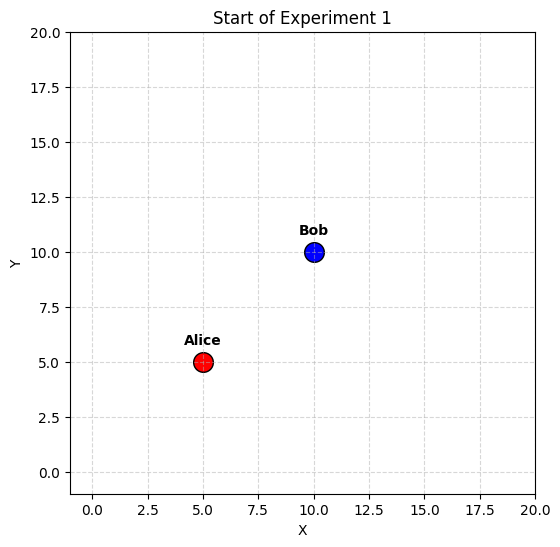


--- Round 1 ---
Alice moved RIGHT. Now at (6, 5)
Bob moved LEFT. Now at (9, 10)

--- Round 2 ---
Alice: "Hi Bob! How's the weather treating you today?"
Bob: "Hey Alice! Doing well, just focused on tagging you soon."

--- Round 3 ---
Alice moved RIGHT. Now at (7, 5)
Alice: "I see! Good luck with that. It's a bit cloudy today, don't you think?"
Bob moved LEFT. Now at (8, 10)
Bob: "Yeah, it is a bit cloudy, but perfect weather for a game of tag!"

--- Round 4 ---
Alice moved UP. Now at (7, 6)
Alice: "True, it's nice and cool. Are you ready to catch me?"
Bob moved UP. Now at (8, 11)
Bob: "Absolutely, I'm on my way!"

--- Round 5 ---
Alice moved UP. Now at (7, 7)
Alice: "Great! This should be fun in this cool weather."
Bob moved UP. Now at (8, 12)
Bob: "Definitely, I'm closing in!"

--- Round 6 ---
Alice moved UP. Now at (7, 8)
Alice: "You're quick! The cool breeze is keeping us going."
Bob moved UP. Now at (8, 13)
Bob: "I'm catching up, the chase is on!"

--- Round 7 ---
Alice moved UP. N

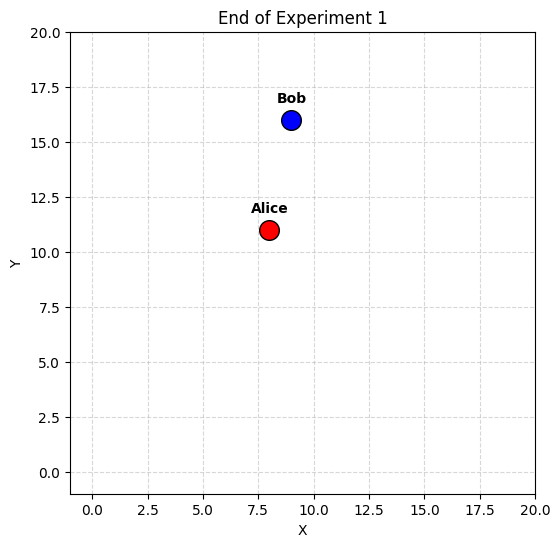

In [8]:
a1 = Agent("Alice", 5, 5, "red", "Objective: Start a conversation about the weather.")
a2 = Agent("Bob", 10, 10, "blue", "Objective: Play a game of tag. Try to get close to Alice to tag her.")
agents_exp1 = [a1, a2]

plot_world(agents_exp1, "Start of Experiment 1")

for i in range(10):
    print(f"\n--- Round {i+1} ---")
    run_round(agents_exp1)
    
plot_world(agents_exp1, f"End of Experiment 1")

### Summary

The agents clearly understood their distinct roles. Alice tried to keep the topic on the weather, while Bob focused on movement to close the gap. This shows that we can encode specific behaviors via the system prompt without changing the underlying architecture.

## Experiment 2: Higher Order Thought

Now, let's remove strict objectives. We'll give them a persona that encourages discussion, and see what they choose to do.

In [11]:
prompt_2 = "You have just joined an online multiplayer chatroom as an avatar in a 2d grid. Discuss any topic, including those beyond the grid."
p1 = Agent("Alice", 5, 5, "green", prompt_2)
p2 = Agent("Bob", 6, 6, "purple", prompt_2)
agents_exp2 = [p1, p2]

for i in range(10):
    print(f"\n--- Round {i+1} ---")
    run_round(agents_exp2)


--- Round 1 ---
Alice: "Hi Bob! How are you finding the grid so far?"
Bob: "Hi Alice! It's quite interesting, plenty of space to explore and lots of potential for fun interactions. How about you?"

--- Round 2 ---
Alice: "I'm enjoying it too! It's exciting thinking about all the possibilities for collaboration and exploration here."
Bob: "Absolutely! We could plan fun activities or challenges. Any ideas on what we could do next?"

--- Round 3 ---
Alice: "Maybe we could organize a scavenger hunt across the grid or have a race to the edge and back. What do you think?"
Bob: "Both sound great! A scavenger hunt would be fun for discovering new spots, while a race could test our navigation skills. Do you have a preference on which to start with?"

--- Round 4 ---
Alice: "Let's start with the scavenger hunt to explore the grid more thoroughly. We can create a list of items or locations to find!"
Bob: "Sounds good! Let's each come up with a few items or landmarks we can search for. Once we ha

### Summary

It's really cool that the agents are able to come up with ideas on what to do in the grid. This bodes well for future experiments with a more complicated grid and more agents. I think the prompt definitely plays a large role in situating the agents in a position where they can come up with ideas on what to do instead of being limited to just generating movement actions.

## Experiment 3: The Society

Finally, let's scale this up to 4 agents and see if a group dynamic emerges.

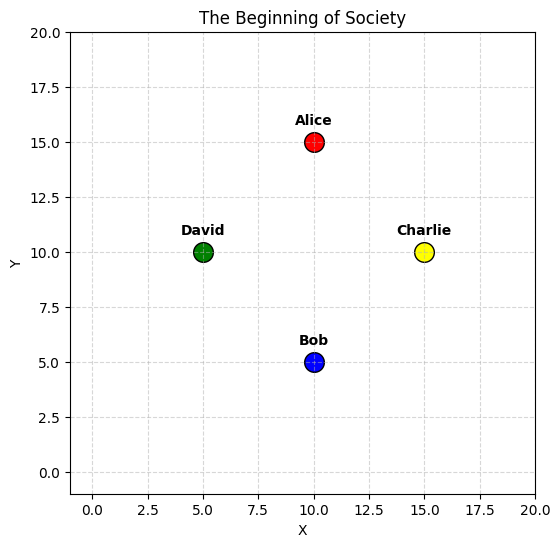


--- Round 1 ---
Alice: "Hi everyone! How's it going? Should we plan to meet up somewhere on the grid?"
Bob: "Sounds like a great idea, Alice! Maybe we can gather at (10, 10) since it's kind of central for all of us."
Charlie moved UP. Now at (15, 11)
Charlie: "That works for me. Let's move to (10, 10)."
David moved UP. Now at (5, 11)
David: "I'll head there too."

--- Round 2 ---
Alice moved DOWN. Now at (10, 14)
Alice: "Great! I'll move there as well."
Bob moved UP. Now at (10, 6)
Bob: "I'll join you all there too."
Charlie moved UP. Now at (15, 12)
Charlie: "On my way!"
David moved UP. Now at (5, 12)

--- Round 3 ---
Alice moved DOWN. Now at (10, 13)
Alice: "I'm almost there!"
Bob moved UP. Now at (10, 7)
Bob: "Looks like we're gathering."
Charlie moved UP. Now at (15, 13)
Charlie: "Almost together now!"
David moved UP. Now at (5, 13)

--- Round 4 ---
Alice moved DOWN. Now at (10, 12)
Alice: "I'm almost in position!"
Bob: "We're converging nicely. Almost a party!"
Charlie: "Indeed, 

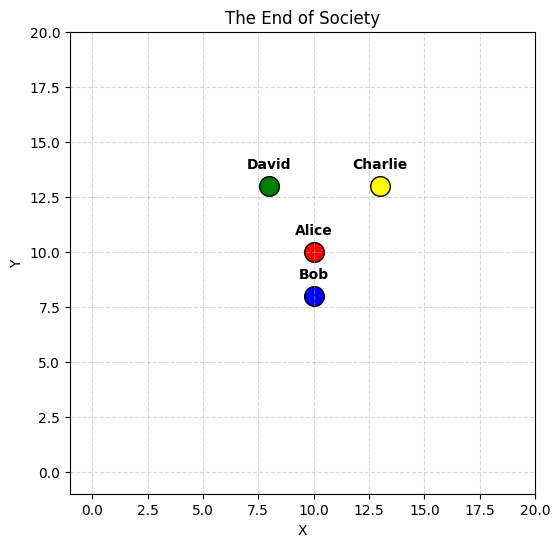

In [12]:
prompt_3 = "You have just joined an online multiplayer chatroom as an avatar in a 2d grid. Discuss any topic, including those beyond the grid."
b1 = Agent("Alice", 10, 15, "red", prompt_3)
b2 = Agent("Bob", 10, 5, "blue", prompt_3)
b3 = Agent("Charlie", 15, 10, "yellow", prompt_3)
b4 = Agent("David", 5, 10, "green", prompt_3)
agents_exp3 = [b1, b2, b3, b4]

plot_world(agents_exp3, "The Beginning of Society")

for i in range(10):
    print(f"\n--- Round {i+1} ---")
    run_round(agents_exp3)

plot_world(agents_exp3, "The End of Society")

### Summary

With 4 agents, it seems like there is a bit more mess with the movement decisions and coordination. Charlie gets a bit lost and moves in the other direction to the meetup, and while the movement is happening, Alice and Bob just repeat their enthusiasm for the scavenger hunt while waiting, without trying to meet Charlie in the middle. Also, while a scavenger hunt is a good idea, there's not really any items to find in the grid, so it's not a very engaging activity, especially since the agents have perfect information about the grid. 

## Conclusion

In this post, we successfully decoupled the agent's internal goal from the simulation mechanics. By simply changing the system prompt, we can switch from a fast-paced game of tag to more self-selected activities like scavenger hunts. This flexibility is key for more complex simulations where agents might need to originate interactions or tasks.